# Analysing Moral Evolution in Lyrics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import json
import glob
from collections import defaultdict
from scipy import stats, signal
from matplotlib.ticker import FormatStrFormatter

pd.set_option('display.max_columns', None)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
wasabi_data = pd.read_csv('/content/drive/MyDrive/My_PhD_Research/WASABI-Billboard-Analysis/Wasabi_MFT_Data/Wasabi_data_themes_genre_mft.csv')

In [4]:
with open('/content/drive/MyDrive/My_PhD_Research/WASABI-Billboard-Analysis/Wasabi_MFT_Data/Wasabi-MFT-1.json') as file1:
    wasabi_mft1 = json.load(file1)

with open('/content/drive/MyDrive/My_PhD_Research/WASABI-Billboard-Analysis/Wasabi_MFT_Data/Wasabi-MFT-2.json') as file2:
    wasabi_mft2 = json.load(file2)

with open('/content/drive/MyDrive/My_PhD_Research/WASABI-Billboard-Analysis/Wasabi_MFT_Data/Wasabi-MFT-3.json') as file3:
    wasabi_mft3 = json.load(file3)

with open('/content/drive/MyDrive/My_PhD_Research/WASABI-Billboard-Analysis/Wasabi_MFT_Data/Wasabi-MFT-4.json') as file4:
    wasabi_mft4 = json.load(file4)

with open('/content/drive/MyDrive/My_PhD_Research/WASABI-Billboard-Analysis/Wasabi_MFT_Data/Wasabi-MFT-fairness-updated.json') as file5:
    wasabi_mft_fairness_updated = json.load(file5)

with open('/content/drive/MyDrive/My_PhD_Research/WASABI-Billboard-Analysis/Wasabi_MFT_Data/Wasabi-MFT-loyalty-updated.json') as file6:
    wasabi_mft_loyalty_updated = json.load(file6)


In [5]:
new_mft_annot = pd.concat([pd.DataFrame(wasabi_mft1), pd.DataFrame(wasabi_mft2).iloc[:, 1:],
                           pd.DataFrame(wasabi_mft3).iloc[:,1:], pd.DataFrame
                           (wasabi_mft4).iloc[:,1:]], axis = 1)

In [6]:
updated_loyalty_fairness = pd.concat([pd.DataFrame(wasabi_mft_fairness_updated), pd.DataFrame(wasabi_mft_loyalty_updated).iloc[:,1:]], axis = 1)

In [7]:
new_mft_annot.rename(columns = {'fairness':'fairness_old', 'loyalty':'loyalty_old'}, inplace=True)


In [8]:
new_mft_annot = pd.concat([new_mft_annot, updated_loyalty_fairness.iloc[:,1:]], axis = 1)

In [9]:
new_mft_annot[['care', 'harm', 'fairness', 'cheating', 'loyalty',
       'betrayal', 'authority', 'subversion', 'purity', 'degradation']]

,care,harm,fairness,cheating,loyalty,betrayal,authority,subversion,purity,degradation
0,0.126650,0.066806,0.453812,0.048531,0.240807,0.096316,0.183997,0.171149,0.077081,0.141319
1,0.056615,0.095776,0.221709,0.030340,0.125543,0.101013,0.239106,0.278636,0.057048,0.225947
2,0.325466,0.124099,0.281115,0.028558,0.201938,0.092575,0.260285,0.185950,0.072906,0.123457
3,0.331744,0.863662,0.183815,0.082307,0.416048,0.216201,0.134697,0.150213,0.168409,0.134458
4,0.537562,0.839044,0.200525,0.052872,0.415731,0.156641,0.274245,0.125807,0.508614,0.116583
...,...,...,...,...,...,...,...,...,...,...
377807,0.231052,0.910888,0.251835,0.244403,0.156491,0.138093,0.136147,0.349804,0.094077,0.681052
377808,0.188758,0.767351,0.372434,0.549935,0.181529,0.132064,0.219414,0.629896,0.048613,0.483592
377809,0.222671,0.119434,0.235792,0.037065,0.425036,0.100339,0.166034,0.167560,0.055819,0.074402
377810,0.479163,0.654306,0.233438,0.068883,0.381935,0.112931,0.307155,0.241096,0.794462,0.123241


In [10]:
wasabi_data = pd.concat([wasabi_data, new_mft_annot], axis = 1)

In [11]:
wasabi_data[['care', 'harm', 'fairness', 'cheating', 'loyalty',
       'betrayal', 'authority', 'subversion', 'purity', 'degradation']].describe()

,care,harm,fairness,cheating,loyalty,betrayal,authority,subversion,purity,degradation
count,377812.000000,377812.000000,377812.000000,377812.000000,377812.000000,377812.000000,377812.000000,377812.000000,377812.000000,377812.000000
mean,0.315356,0.417998,0.285287,0.246858,0.336679,0.175012,0.225546,0.282360,0.124217,0.281502
std,0.248006,0.295233,0.113839,0.243723,0.147417,0.117489,0.105960,0.172801,0.151106,0.247069
min,0.025012,0.027016,0.153899,0.023450,0.102454,0.074253,0.084483,0.072548,0.037793,0.044437
25%,0.098486,0.135780,0.206405,0.054316,0.223280,0.105525,0.152043,0.140255,0.055890,0.096864
50%,0.233827,0.350124,0.246915,0.131276,0.302603,0.131634,0.198115,0.231268,0.068150,0.170702
75%,0.503160,0.707876,0.325904,0.392008,0.419232,0.191543,0.264811,0.387861,0.101488,0.392030
max,0.916495,0.939205,0.897328,0.961762,0.954087,0.860090,0.922528,0.938251,0.928652,0.955908


## Mapping Genre Tags with the Main Genres

In [12]:
import ast
import re

# Keywords for mapping genres to broader categories based on musicmap: https://musicmap.info
keywords_by_genre = {
    'Rock': ['rock', 'aor', 'grunge', 'alternative rock'],
    'Punk': ['punk', 'emo', 'screamo', 'no wave', 'new wave',
             'ska', '2-tone', '2 tone', 'synthpop', 'crustcore',
             'd beat', 'd-beat', 'discore'],
    'Metal': ['metal', 'heavy metal', 'grindcore', 'nwobhm'],
    'Pop': ['pop', 'chillwave', 'indietronica', 'schlager',
            'bubblegum', 'singer-songwriter', 'singer/songwriter',
            'shoegaze', 'britpop', 'futurepop', 'indie'],
    'Latin': ['latin', 'cumbia', 'salsa', 'merengue', 'bachata', 'tango', 'brazilian', 'mexican', 'samba', 'mpb', 'bossa nova'],
    'Rap/Hip Hop': ['rap', 'hip-hop', 'hip hop', 'trap', 'gangsta'],
    'R&b and Soul/Funk': ['funk', 'soul', 'disco', 'rnb', 'r&b', 'reggae'],
    'Jazz and Blues': ['jazz', 'bop', 'swing', 'dixieland', 'blues', 'boogie'],
    'Classical': ['classical', 'classic', 'opera', 'symphony', 'soprano',
                  'tenor', 'contralto', 'baritone', 'violinist', 'pianist', 'conductor', 'orchestra'],
    'Country and Folk': ['folk', 'neofolk', 'country'],
    'Religious': ['christian', 'gospel'],
    'Experimental': ['experimental'],
    'Electronic': ['electronica', 'electronic', 'edm', 'electronic dance', 'dance and electronica',
                   'techno', 'house', 'eurodance', 'nu disco', 'funktronica', 'complextro',
                   'moombahton', 'drum and bass', 'breakcore', 'ambient', 'electropop', 'trance']
}

def map_genres(genres_input):
    matched_categories = set()

    # Handle cases where the input is None or empty
    if not genres_input:
        return "Other"

    # Determine if genres_input is a list or a string.
    if isinstance(genres_input, list):
        genres_list = genres_input
    elif isinstance(genres_input, str):
        # If string looks like a list (begins with '[' and ends with ']') try to convert it
        if genres_input.strip().startswith('[') and genres_input.strip().endswith(']'):
            try:
                genres_list = ast.literal_eval(genres_input)
                # Ensure the conversion produced a list, otherwise fall back on comma splitting.
                if not isinstance(genres_list, list):
                    genres_list = genres_input.split(',')
            except Exception:
                # If conversion fails, try splitting on commas.
                genres_list = genres_input.split(',')
        else:
            # When it's a comma-separated string without list brackets.
            genres_list = genres_input.split(',')
    else:
        return "Other"

    # Clean the list: strip whitespace and remove any empty strings.
    genres_list = [genre.strip() for genre in genres_list if genre.strip()]
    genres_list =  genres_list[:2]

    if not genres_list:
        return "Other"

    # Loop over all genres in the list
    for genre in genres_list:
        for category, keywords in keywords_by_genre.items():
            for keyword in keywords:
                # Use re.escape on keyword to safely match literal keyword values
                pattern = rf'\b{re.escape(keyword)}\b'
                if re.search(pattern, genre, re.IGNORECASE):
                    matched_categories.add(category)
                    break  # No need to check further keywords for this category and genre

    # Return a sorted, comma-separated string of matched categories or 'Other' if nothing found.
    return ','.join(sorted(matched_categories)) if matched_categories else 'Other'

# Example usage with a DataFrame called wasabi_data:
wasabi_data['mapped_genres'] = wasabi_data['dbp_genre'].apply(map_genres)


In [13]:
wasabi_data[['mapped_genres','dbp_genre']][:10]

,mapped_genres,dbp_genre
0,"Country and Folk,Jazz and Blues","['Rhythm and blues', 'Country music', 'Pop mus..."
1,"Jazz and Blues,Latin","['Latin jazz', 'Jazz fusion', 'World music']"
2,"Jazz and Blues,R&b and Soul/Funk","['Soul music', 'Rhythm and blues', 'Smooth sou..."
3,"Jazz and Blues,R&b and Soul/Funk","['Soul music', 'Rhythm and blues', 'Smooth sou..."
4,"Jazz and Blues,R&b and Soul/Funk","['Soul music', 'Rhythm and blues', 'Smooth sou..."
5,"Jazz and Blues,R&b and Soul/Funk","['Soul music', 'Rhythm and blues', 'Smooth sou..."
6,"Jazz and Blues,R&b and Soul/Funk","['Soul music', 'Rhythm and blues', 'Smooth sou..."
7,"Jazz and Blues,R&b and Soul/Funk","['Soul music', 'Rhythm and blues', 'Smooth sou..."
8,"Jazz and Blues,R&b and Soul/Funk","['Soul music', 'Rhythm and blues', 'Smooth sou..."
9,"Jazz and Blues,R&b and Soul/Funk","['Soul music', 'Rhythm and blues', 'Smooth sou..."


In [14]:
dummy_genres = wasabi_data['mapped_genres'].str.get_dummies(sep=',')


wasabi_data = pd.concat([wasabi_data, dummy_genres], axis=1)

In [15]:
wasabi_data[['dbp_genre', 'mapped_genres', 'Classical', 'Country and Folk', 'Electronic',
       'Experimental', 'Jazz and Blues', 'Latin', 'Metal', 'Other', 'Pop',
       'Punk', 'R&b and Soul/Funk', 'Rap/Hip Hop', 'Religious', 'Rock' ]]

,dbp_genre,mapped_genres,Classical,Country and Folk,Electronic,Experimental,Jazz and Blues,Latin,Metal,Other,Pop,Punk,R&b and Soul/Funk,Rap/Hip Hop,Religious,Rock
0,"['Rhythm and blues', 'Country music', 'Pop mus...","Country and Folk,Jazz and Blues",0,1,0,0,1,0,0,0,0,0,0,0,0,0
1,"['Latin jazz', 'Jazz fusion', 'World music']","Jazz and Blues,Latin",0,0,0,0,1,1,0,0,0,0,0,0,0,0
2,"['Soul music', 'Rhythm and blues', 'Smooth sou...","Jazz and Blues,R&b and Soul/Funk",0,0,0,0,1,0,0,0,0,0,1,0,0,0
3,"['Soul music', 'Rhythm and blues', 'Smooth sou...","Jazz and Blues,R&b and Soul/Funk",0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,"['Soul music', 'Rhythm and blues', 'Smooth sou...","Jazz and Blues,R&b and Soul/Funk",0,0,0,0,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377807,"['Heavy metal music', 'Progressive rock', 'Har...","Metal,Rock",0,0,0,0,0,0,1,0,0,0,0,0,0,1
377808,"['Heavy metal music', 'Progressive rock', 'Har...","Metal,Rock",0,0,0,0,0,0,1,0,0,0,0,0,0,1
377809,"['Heavy metal music', 'Progressive rock', 'Har...","Metal,Rock",0,0,0,0,0,0,1,0,0,0,0,0,0,1
377810,"['Heavy metal music', 'Progressive rock', 'Har...","Metal,Rock",0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [16]:
wasabi_billboard =  wasabi_data[wasabi_data['is_billboard']==True]
wasabi_billboard.shape

(10841, 92)

# Genre MFT Correlations

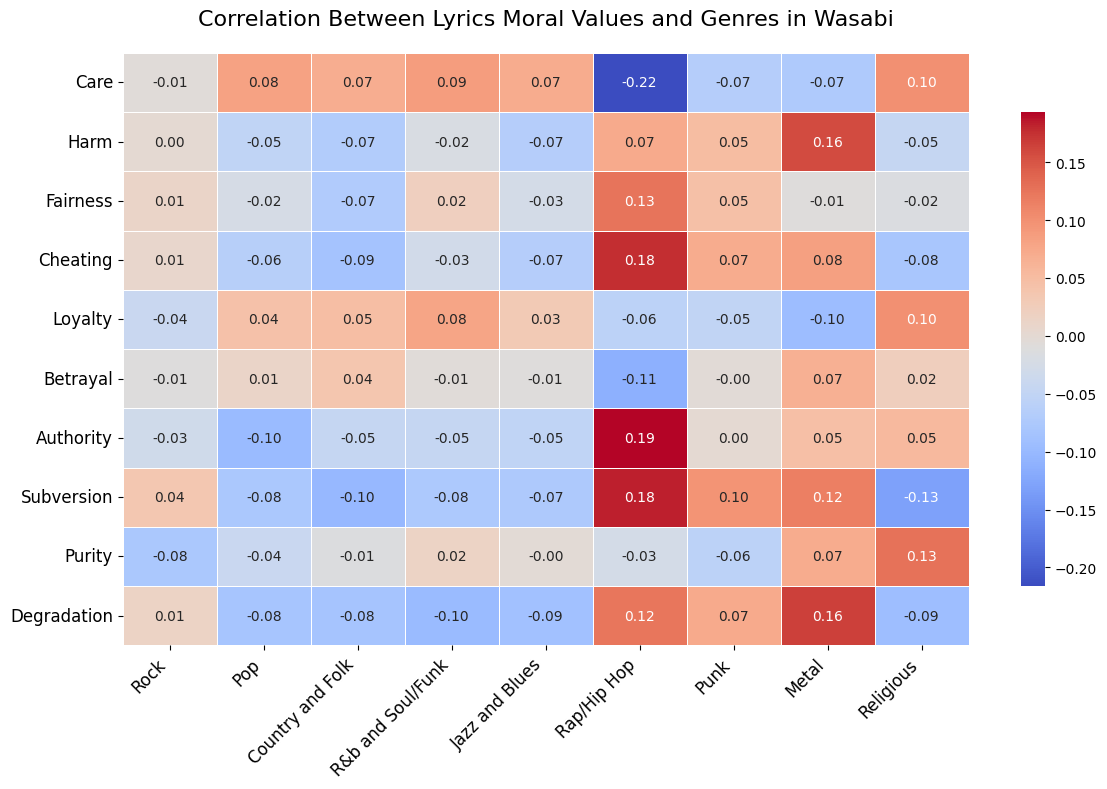

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
# List of moral values
moral_values = ["care", "harm", "fairness", "cheating", "loyalty", "betrayal", "authority", "subversion", "purity", "degradation"]

# Compute correlation between moral foundations and genres
genres = ['Rock', 'Pop','Country and Folk', 'R&b and Soul/Funk', 'Jazz and Blues',
       'Rap/Hip Hop', 'Punk', 'Metal', 'Religious']

genre_mf_correlation = wasabi_data[moral_values + genres].corr('spearman').loc[moral_values, genres]
genre_mf_correlation.index = genre_mf_correlation.index.str.capitalize()
# Display as a heatmap
plt.figure(figsize=(12, 8))  # Increased figure size for better readability
sns.heatmap(
    genre_mf_correlation,
    annot=True,
    cmap="coolwarm",  # Changed colormap to a more visually appealing one
    fmt=".2f",
    linewidths=0.5,  # Add separation between cells
    linecolor="white",  # Use a lighter grid line color
    annot_kws={"fontsize": 10},  # Adjust annotation font size
    cbar_kws={"shrink": 0.8}  # Adjust colorbar size
)

# Rotate x-axis labels
plt.xticks(rotation=45, ha="right", fontsize=12)  # Rotate and adjust alignment
plt.yticks(fontsize=12)  # Adjust y-axis label font size

# Add title with better padding
plt.title("Correlation Between Lyrics Moral Values and Genres in Wasabi", fontsize=16, pad=20)

# Ensure proper spacing and display the plot
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/My_PhD_Research/WASABI-Billboard-Analysis/Wasabi_Graphs/Genre_MFT_Corr.pdf', dpi = 300)
plt.show()

## Moral Expressions Distributions Across Genres:

In [18]:
wasabi_data.rename(columns = {'Country and Folk':'Country/Folk', 'R&b and Soul/Funk':'R&b/Soul/Funk', 'Jazz and Blues':'Jazz/Blues' }, inplace = True)

In [ ]:
# Aggregate moral foundations by genre
genre_columns = ['Rock', 'Pop','Country/Folk', 'R&b/Soul/Funk', 'Jazz/Blues',
       'Rap/Hip Hop', 'Punk', 'Metal', 'Religious']

# Melt the DataFrame to long format
mf_by_genre = wasabi_data.melt(
    id_vars=moral_values,
    value_vars=genre_columns,
    var_name="Genre",
    value_name="Is_Genre"
)

# Filter rows where the genre is present (Is_Genre == 1)
mf_by_genre = mf_by_genre[mf_by_genre["Is_Genre"] == 1]

# Group by Genre/calculate mean for each moral foundation
mf_by_genre_mean = mf_by_genre.groupby("Genre")[moral_values].mean().reset_index()


In [ ]:
mf_by_genre_mean

,Genre,care,harm,fairness,cheating,loyalty,betrayal,authority,subversion,purity,degradation
0,Country/Folk,0.346407,0.374949,0.273629,0.207775,0.348928,0.183223,0.216433,0.244279,0.122381,0.233679
1,Jazz/Blues,0.370200,0.358423,0.278992,0.204067,0.347591,0.172768,0.210104,0.243450,0.115868,0.217918
2,Metal,0.234305,0.592941,0.280581,0.308354,0.294126,0.195912,0.248956,0.352709,0.151741,0.457362
3,Pop,0.353475,0.385260,0.281552,0.215211,0.349423,0.176444,0.206543,0.252512,0.113087,0.239593
4,Punk,0.255631,0.467453,0.299349,0.299430,0.314846,0.170807,0.221799,0.336107,0.102042,0.336614
5,R&b/Soul/Funk,0.405758,0.393307,0.295490,0.221805,0.376134,0.176389,0.211969,0.241103,0.119839,0.200455
6,Rap/Hip Hop,0.170026,0.479566,0.315547,0.392772,0.303291,0.140067,0.275504,0.397561,0.103316,0.358085
7,Religious,0.437903,0.363776,0.285881,0.161276,0.413589,0.187050,0.274403,0.193776,0.296357,0.192810
8,Rock,0.308209,0.416971,0.286353,0.246056,0.328122,0.171747,0.219687,0.286230,0.113177,0.280751


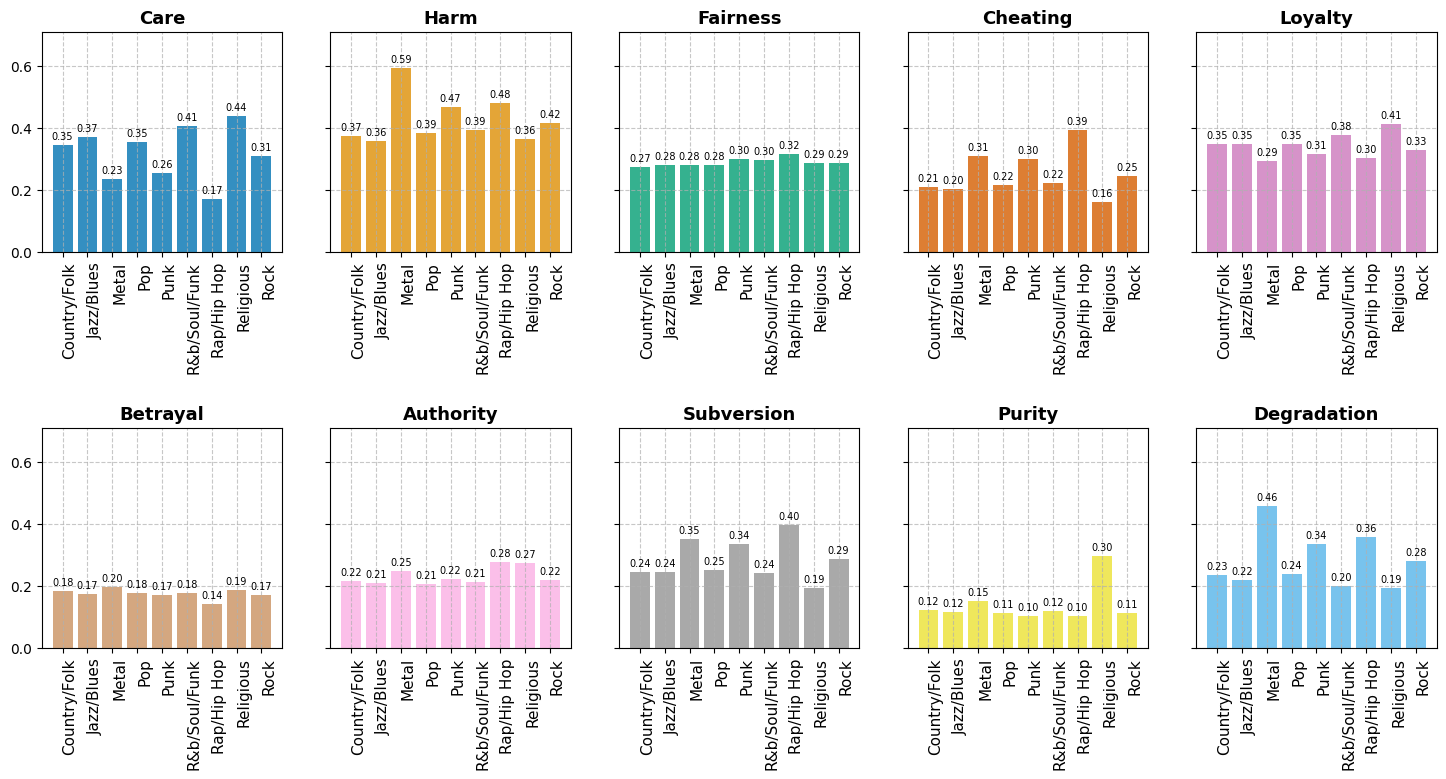

In [ ]:
plt.style.use('default')
plt.rcParams.update({'font.family': 'sans-serif'})  # Use standard sans-serif font

# Adjust the figure size for wider layout
fig = plt.figure(figsize=(18, 8))  # Slightly wider width and smaller height
n_cols = 5
n_rows = 2


# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.8, wspace=0.2)

# Use a colorblind-friendly palette
colors = sns.color_palette("colorblind", n_colors=len(moral_values))

# Calculate the global maximum for consistent y-axis limits
global_ymax = max(mf_by_genre_mean[mf].max() for mf in moral_values)

for idx, mf in enumerate(moral_values):
    ax = fig.add_subplot(n_rows, n_cols, idx + 1)

    # Create bar plot without error bars
    bars = ax.bar(
        mf_by_genre_mean["Genre"],
        mf_by_genre_mean[mf],
        color=colors[idx],
        alpha=0.8
    )

    # Customize the plot
    ax.set_title(mf.capitalize(), fontsize=13, fontweight='bold')
    ax.set_xticks(range(len(mf_by_genre_mean["Genre"])))
    ax.set_xticklabels(mf_by_genre_mean["Genre"], rotation=90, ha='left', fontsize=11)  # Rotate and resize labels
    ax.set_ylim(0, global_ymax * 1.2)

    # Show y-axis labels for the first column only
    if idx % n_cols == 0:
        ax.set_ylabel("", fontsize=11, labelpad=5)
    else:
        ax.set_yticklabels([])  # Hide y-tick labels for other columns

    # Add grid for better readability
    ax.grid(linestyle='--', alpha=0.7)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.,
            height + (global_ymax * 0.02),
            f'{height:.2f}',
            ha='center', va='bottom', fontsize=7
        )

# Save as a high-resolution PDF for publication
plt.savefig('/content/drive/MyDrive/My_PhD_Research/WASABI-Billboard-Analysis/Wasabi_Graphs/Overall_Wasabi_Genres_MFT_Averages_5_2.pdf', dpi=300, bbox_inches='tight')
plt.show()


# **Evolution of Moral Foundations (Temporal Analysis)**

In [19]:
# Convert song_year_combined to datetime
wasabi_data['song_year_combined'] = pd.to_datetime(wasabi_data['song_year_combined'], format='%Y')

# List of moral values
moral_values = ["care", "harm", "fairness", "cheating", "loyalty", "betrayal", "authority", "subversion", "purity", "degradation"]

# Overall time series for all moral values
overall_trends = wasabi_data.groupby('song_year_combined')[moral_values].mean()

# Time series for each moral value grouped by artist_gender
artist_gender_trends = wasabi_data.groupby(['song_year_combined', 'artist_gender'])[moral_values].mean().reset_index()


## Time Series Visual Representation

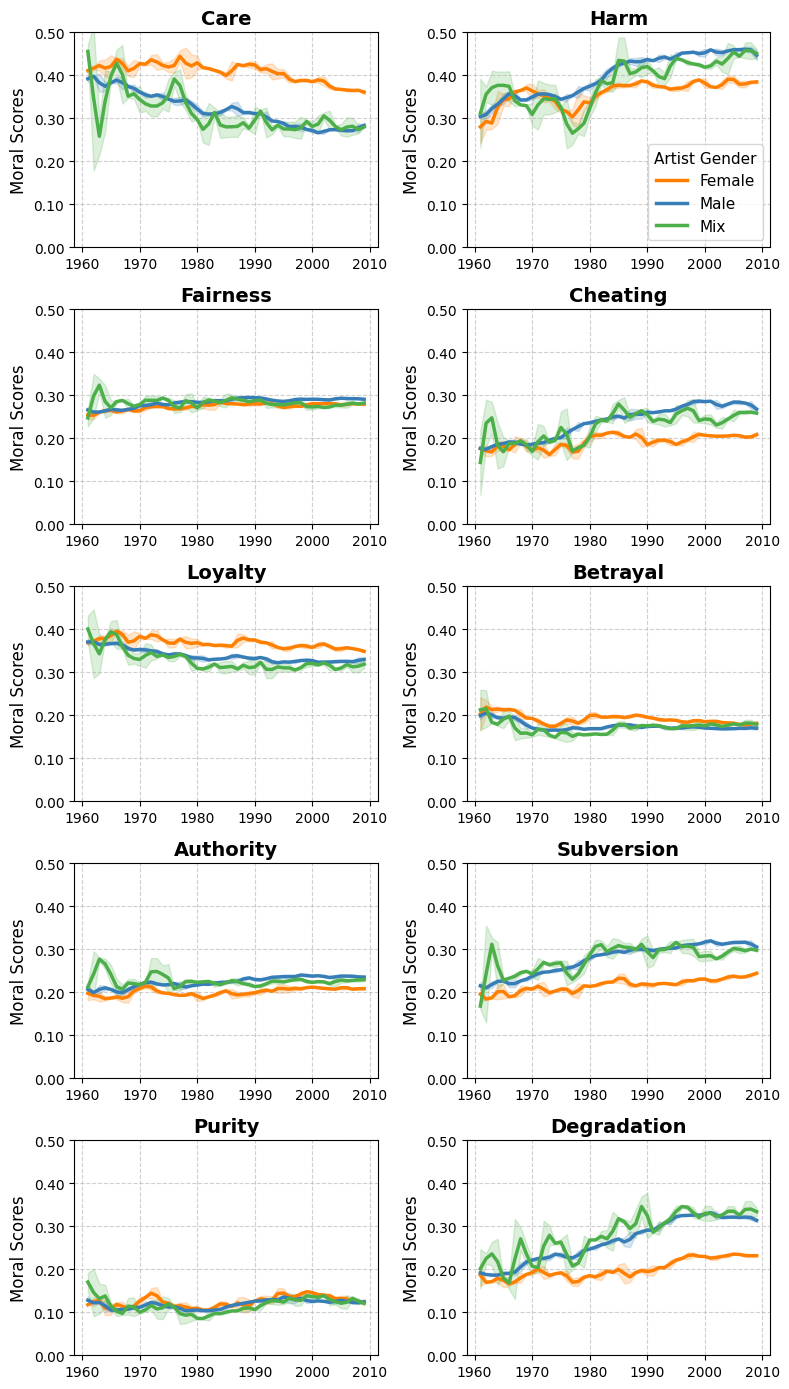

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def plot_trend_with_ci_inline(data, x, y, hue, title, xlabel, ylabel, ci_window=5, custom_palette=None, show_legend=False):
    # Create a rolling mean and confidence interval
    data = data.copy()
    data["mean"] = data.groupby(hue)[y].transform(lambda x: x.rolling(ci_window, center=True).mean())
    data["ci"] = data.groupby(hue)[y].transform(lambda x: x.rolling(ci_window, center=True).std())

    # Plot using seaborn with a custom palette
    sns.lineplot(data=data, x=x, y="mean", hue=hue, ci=None, linewidth=2.5, palette=custom_palette)
    for group in data[hue].unique():
        group_data = data[data[hue] == group]
        plt.fill_between(
            group_data[x],
            group_data["mean"] - group_data["ci"],
            group_data["mean"] + group_data["ci"],
            alpha=0.2,
            color=custom_palette[group]
        )

    # Enhance the plot appearance
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    if show_legend:
        plt.legend(title="Artist Gender", title_fontsize=11, fontsize=11, loc="best")
    else:
        plt.legend().remove()   # Remove legend for other subplots


# Prepare data: Filter non-binary genders
filtered_data = artist_gender_trends[artist_gender_trends["artist_gender"].isin(["Male", "Female", "Mix"])]

years_span = filtered_data['song_year_combined'].nunique()
ci_window = 2 #max(2, int(years_span * 0.05))  # 5% of year range


# Define a custom color palette
gender_palette = {"Male": "#377eb8", "Female": "#ff7f00", "Mix": "#4daf4a"}

# List of moral values to iterate over
moral_values = ["care", "harm", "fairness", "cheating", "loyalty",
                "betrayal", "authority", "subversion", "purity", "degradation"]

# Plot in a grid (2 graphs per row, 5 rows in total)
rows = 5
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(8, 14))

for i, moral_value in enumerate(moral_values):
    row = i // cols
    col = i % cols
    plt.sca(axes[row, col])  # Set current axis
    # Show legend only for "Care" and "Loyalty"
    show_legend = moral_value in ["harm"]

    plot_trend_with_ci_inline(
        data=filtered_data,
        x="song_year_combined",
        y=moral_value,
        hue="artist_gender",
        title=f"{moral_value.capitalize()}",
        xlabel="",
        # ylabel=f"{moral_value.capitalize()} Scores",
        ylabel= "Moral Scores",
        ci_window=2,
        custom_palette=gender_palette,  # Apply custom colors
        show_legend=show_legend
    )
    # Format y-axis to 2 decimal places
    axes[row, col].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.ylim(0, 0.5)  # Set y-axis range

    # Adjust spacing between rows to be tighter and columns
    # plt.subplots_adjust(hspace=0.4, wspace=7)

# Adjust layout and display
    plt.tight_layout()
# plt.savefig(f"/content/drive/MyDrive/My_PhD_Research/WASABI-Billboard-Analysis/Wasabi_Graphs/Overall_MFT_trends_Wasabi_v3.pdf", dpi=300,bbox_inches="tight")
plt.show()


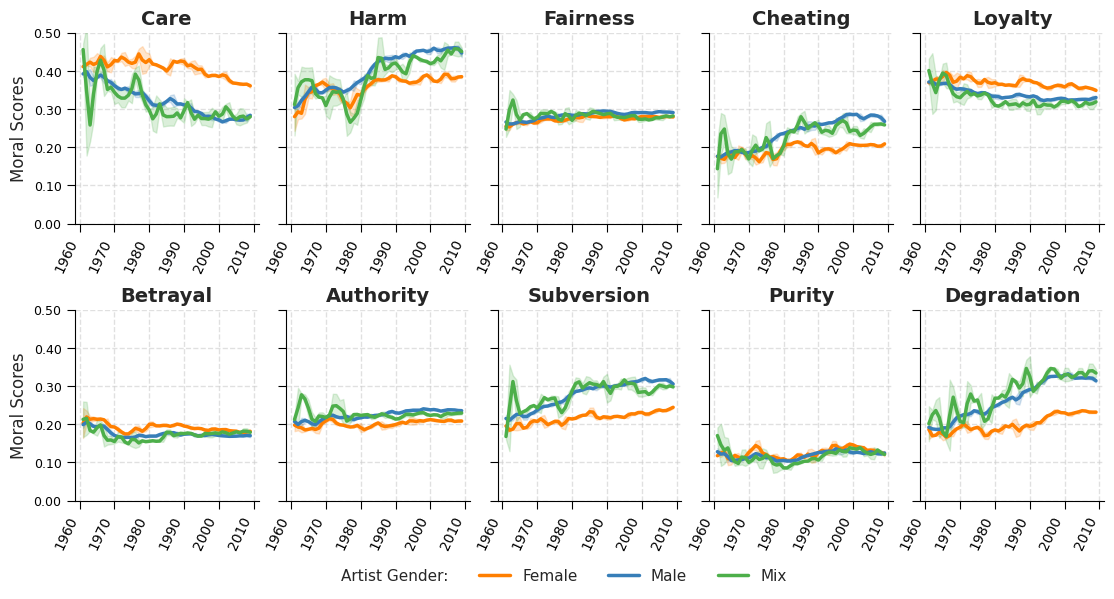

In [ ]:
# Import the missing formatter
from matplotlib.ticker import FormatStrFormatter
# Import for the new legend
import matplotlib.patches as mpatches

if 'artist_gender_trends' not in locals():
    print("Creating placeholder data for 'artist_gender_trends'...")
    years = np.arange(1960, 2021)
    genders = ["Male", "Female", "Mix"]
    moral_values_list = ["care", "harm", "fairness", "cheating", "loyalty",
                         "betrayal", "authority", "subversion", "purity", "degradation"]
    data = []
    for year in years:
        for gender in genders:
            entry = {"song_year_combined": year, "artist_gender": gender}
            for val in moral_values_list:
                entry[val] = np.random.rand() * 0.3 + 0.1 + (genders.index(gender) * 0.05)
            data.append(entry)
    artist_gender_trends = pd.DataFrame(data)
    print("Placeholder data created.")


def plot_trend_with_ci_inline(data, x, y, hue, title, xlabel, ylabel, ci_window=5, custom_palette=None, show_legend=False):
    """
    Create a professional plot with confidence intervals and custom colors.
    (Function definition is unchanged)
    """
    # Create a rolling mean and confidence interval
    data = data.copy()
    data["mean"] = data.groupby(hue)[y].transform(lambda x: x.rolling(ci_window, center=True).mean())
    data["ci"] = data.groupby(hue)[y].transform(lambda x: x.rolling(ci_window, center=True).std())

    # Plot using seaborn with a custom palette
    sns.lineplot(data=data, x=x, y="mean", hue=hue, ci=None, linewidth=2.5, palette=custom_palette)

    for group in data[hue].unique():
        group_data = data[data[hue] == group]
        plt.fill_between(
            group_data[x],
            group_data["mean"] - group_data["ci"],
            group_data["mean"] + group_data["ci"],
            alpha=0.2,
            color=custom_palette[group]
        )

    # Enhance the plot appearance
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)

    if show_legend:
        plt.legend(title="Artist Gender", title_fontsize=11, fontsize=11, loc="best")
    else:
        if plt.gca().get_legend():
            plt.gca().get_legend().remove()


    sns.despine()

    ax = plt.gca()
    ax.spines['left'].set_linewidth(0.8)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_linewidth(0.8)
    ax.spines['bottom'].set_color('black')


    ax.tick_params(
        axis='both',     # Apply to both x and y
        which='both',    # Apply to major and minor ticks
        direction='out', # Draw ticks outside the axis lines
        colors='black',  # Make ticks black
        width=0.8,       # Make ticks thicker
        left=True,       # Show ticks on the left (Y-axis)
        bottom=True      # Show ticks on the bottom (X-axis)
    )

# Data Preparation
filtered_data = artist_gender_trends[artist_gender_trends["artist_gender"].isin(["Male", "Female", "Mix"])]
ci_window = 2
gender_palette = {"Male": "#377eb8", "Female": "#ff7f00", "Mix": "#4daf4a"}
moral_values = ["care", "harm", "fairness", "cheating", "loyalty",
                "betrayal", "authority", "subversion", "purity", "degradation"]

# Plotting Grid
rows = 2
cols = 5

# Adjust figsize (taller, narrower) and remove sharex=True**
fig, axes = plt.subplots(rows, cols, figsize=(11.7, 6.0), sharey=True)
axes_flat = axes.flatten()

for i, moral_value in enumerate(moral_values):
    ax = axes_flat[i]
    plt.sca(ax)

    is_bottom_row = (i // cols == rows - 1)
    is_first_col = (i % cols == 0)

    plot_trend_with_ci_inline(
        data=filtered_data,
        x="song_year_combined",
        y=moral_value,
        hue="artist_gender",
        title=f"{moral_value.capitalize()}",
        xlabel="" if is_bottom_row else "", # X-label "Year" only on bottom
        ylabel="Moral Scores" if is_first_col else "",
        ci_window=ci_window,
        custom_palette=gender_palette,
        show_legend=False
    )

    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.ylim(0, 0.5)

for ax in axes_flat:
    # Set rotation and horizontal alignment for better spacing
    plt.setp(ax.get_xticklabels(), rotation=65, ha='right', fontsize=10)

# Add an inline, shared legend (code unchanged)
handles, labels = axes_flat[0].get_legend_handles_labels()
title_handle = mpatches.Patch(color='none', label='Artist Gender:')
all_handles = [title_handle] + handles
all_labels = ['Artist Gender:'] + labels

fig.legend(all_handles, all_labels,
           loc='lower center',
           bbox_to_anchor=(0.5, -0.02), # Slightly adjusted position
           ncol=4,
           fontsize=11,
           frameon=False)

# Adjust layout for new figure shape**
plt.subplots_adjust(
    left=0.1,     # Increased left margin
    right=0.98,
    top=0.92,     # Adjusted for new height
    bottom=0.14,  # Adjusted for new height
    hspace=0.45,   # Increased horizontal spacing between rows
    wspace=0.15   # Increased vertical spacing between columns
)
# plt.tight_layout()
plt.savefig(f"/content/drive/MyDrive/My_PhD_Research/WASABI-Billboard-Analysis/Wasabi_Graphs/Overall_MFT_trends_Wasabi_5_2.pdf", dpi=300,bbox_inches="tight")
plt.show()

In [20]:
# For large dataset (300k)
print("=== WASABI LARGE DATASET ===")
print(f"Total observations: {len(wasabi_data)}")
print(f"Year range: {wasabi_data['song_year_combined'].dt.year.min()} to {wasabi_data['song_year_combined'].dt.year.max()}")
print(f"Years covered: {wasabi_data['song_year_combined'].dt.year.max() - wasabi_data['song_year_combined'].dt.year.min()}")
print(f"Unique years: {wasabi_data['song_year_combined'].dt.year.nunique()}")
print(f"Average observations per year: {len(wasabi_data) / wasabi_data['song_year_combined'].dt.year.nunique():.0f}")


=== WASABI LARGE DATASET ===
Total observations: 377812
Year range: 1960 to 2009
Years covered: 49
Unique years: 50
Average observations per year: 7556


## **Generalized Additive Models (GAMs) for Analysig Trends of Moral Expressions in Lyrics**


In [22]:
!pip install pygam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 1.6 MB/s eta 0:00:00


In [23]:
import pandas as pd
from pygam import LinearGAM, s, f, te
import numpy as np

# Data Preparation
artist_gender_trends['year'] = pd.to_datetime(
    artist_gender_trends['song_year_combined']
).dt.year
artist_gender_trends['gender_code'] = (
    artist_gender_trends['artist_gender'].astype('category').cat.codes
)

moral_values = [
    "care", "harm", "fairness", "cheating", "loyalty", "betrayal",
    "authority", "subversion", "purity", "degradation"
]
BONFERRONI_ALPHA = 0.05 / len(moral_values)  # 0.005

# Helper Functions
def format_p_value(p_value):
    """Format p-value with scientific notation for small values."""
    if p_value < 0.0001:
        return f"{p_value:.2e}"
    elif p_value < 0.001:
        return f"{p_value:.4f}"
    else:
        return f"{p_value:.3f}"

def calculate_trend(gam_model, year_values):
    """Calculate trend direction and magnitude."""
    start_pred = gam_model.predict(np.min(year_values)).item()
    end_pred = gam_model.predict(np.max(year_values)).item()

    direction = "Increase" if end_pred > start_pred else "Decline"
    percent_change = ((end_pred - start_pred) / abs(start_pred)) * 100

    return direction, percent_change

# Run GAMs for Each Moral Foundation
results = []

for moral_value in moral_values:
    # Prepare data
    X = artist_gender_trends[['year', 'gender_code']].values
    y = artist_gender_trends[moral_value].values

    # Model 1: Main effect of year
    gam_main = LinearGAM(s(0)).fit(X[:, 0], y)
    p_value_year = gam_main.statistics_['p_values'][0]

    # Model 2: Interaction model
    gam_interaction = LinearGAM(f(1) + s(0) + te(0, 1)).fit(X, y)
    p_value_interaction = gam_interaction.statistics_['p_values'][2]
    deviance_explained = gam_interaction.statistics_['pseudo_r2']['explained_deviance']

    # Calculate trend
    trend_direction, percent_change = calculate_trend(gam_main, X[:, 0])

    # Store results
    results.append({
        "Moral Foundation": moral_value.title(),
        "Deviance Explained (%)": round(deviance_explained * 100, 2),
        "Magnitude (% Change)": round(percent_change, 2),
        "Trend Direction": trend_direction,
        "P-value (Year)": format_p_value(p_value_year),
        "P-value (Gender × Year)": format_p_value(p_value_interaction),
        "Sig (Year)": "***" if p_value_year < 0.001 else "**" if p_value_year < 0.01 else "*" if p_value_year < 0.05 else "ns",
        "Sig (Interaction)": "***" if p_value_interaction < 0.001 else "**" if p_value_interaction < 0.01 else "*" if p_value_interaction < 0.05 else "ns",
    })

# Create and Format Results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("Deviance Explained (%)", ascending=False)

print("=" * 130)
print("GAM ANALYSIS: MORAL FOUNDATIONS OVER TIME")
print("=" * 130)
print(results_df.to_string(index=False))
print("=" * 130)
print(f"\nSignificance codes: *** p < 0.001, ** p < 0.01, * p < 0.05, ns = not significant")
print(f"Bonferroni-corrected threshold: α = {BONFERRONI_ALPHA:.4f}")

GAM ANALYSIS: MORAL FOUNDATIONS OVER TIME
Moral Foundation  Deviance Explained (%)  Magnitude (% Change) Trend Direction P-value (Year) P-value (Gender × Year) Sig (Year) Sig (Interaction)
     Degradation                   91.73                 52.25        Increase       1.06e-11                1.11e-16        ***               ***
            Harm                   88.32                 49.13        Increase       1.11e-16                1.11e-16        ***               ***
      Subversion                   88.25                 40.91        Increase       8.33e-07                1.11e-16        ***               ***
            Care                   85.69                -24.38         Decline         0.0001                1.11e-16        ***               ***
         Loyalty                   83.40                -11.26         Decline       3.47e-06                1.11e-16        ***               ***
        Cheating                   82.73                 47.99        Increa

## **Evolution of Lyrical Topics based on LDA (Temporal Analysis)**

In [ ]:
# Convert song_year_combined to datetime
wasabi_data['song_year_combined'] = pd.to_datetime(wasabi_data['song_year_combined'], format='%Y')

# List of song topics
song_topics = ['Love and Emotions', 'Movement and Change',
       'Passion and Desire', 'Profanity and Aggression',
       'Spiritual and Dreamy', 'Violence and Darkness']

# Overall time series for all song topics
overall_trends = wasabi_data.groupby('song_year_combined')[song_topics].mean()

# Time series for each moral value grouped by artist_gender
artist_gender_trends = wasabi_data.groupby(['song_year_combined', 'artist_gender'])[song_topics].mean().reset_index()

In [ ]:
artist_gender_trends

,song_year_combined,artist_gender,Love and Emotions,Movement and Change,Passion and Desire,Profanity and Aggression,Spiritual and Dreamy,Violence and Darkness
0,1960-01-01,Female,0.370690,0.133621,0.120690,0.008621,0.224138,0.142241
1,1960-01-01,Male,0.342193,0.211517,0.100775,0.007752,0.193798,0.143965
2,1960-01-01,Mix,0.289474,0.236842,0.026316,0.000000,0.394737,0.052632
3,1961-01-01,Female,0.476190,0.133333,0.057143,0.006349,0.231746,0.095238
4,1961-01-01,Male,0.397915,0.208514,0.094700,0.006082,0.194613,0.098175
...,...,...,...,...,...,...,...,...
145,2008-01-01,Male,0.322576,0.143375,0.056938,0.055232,0.211828,0.210051
146,2008-01-01,Mix,0.318923,0.140294,0.044046,0.021207,0.274062,0.201468
147,2009-01-01,Female,0.451291,0.147485,0.071817,0.016085,0.198913,0.114409
148,2009-01-01,Male,0.312042,0.141209,0.055971,0.050915,0.218970,0.220893


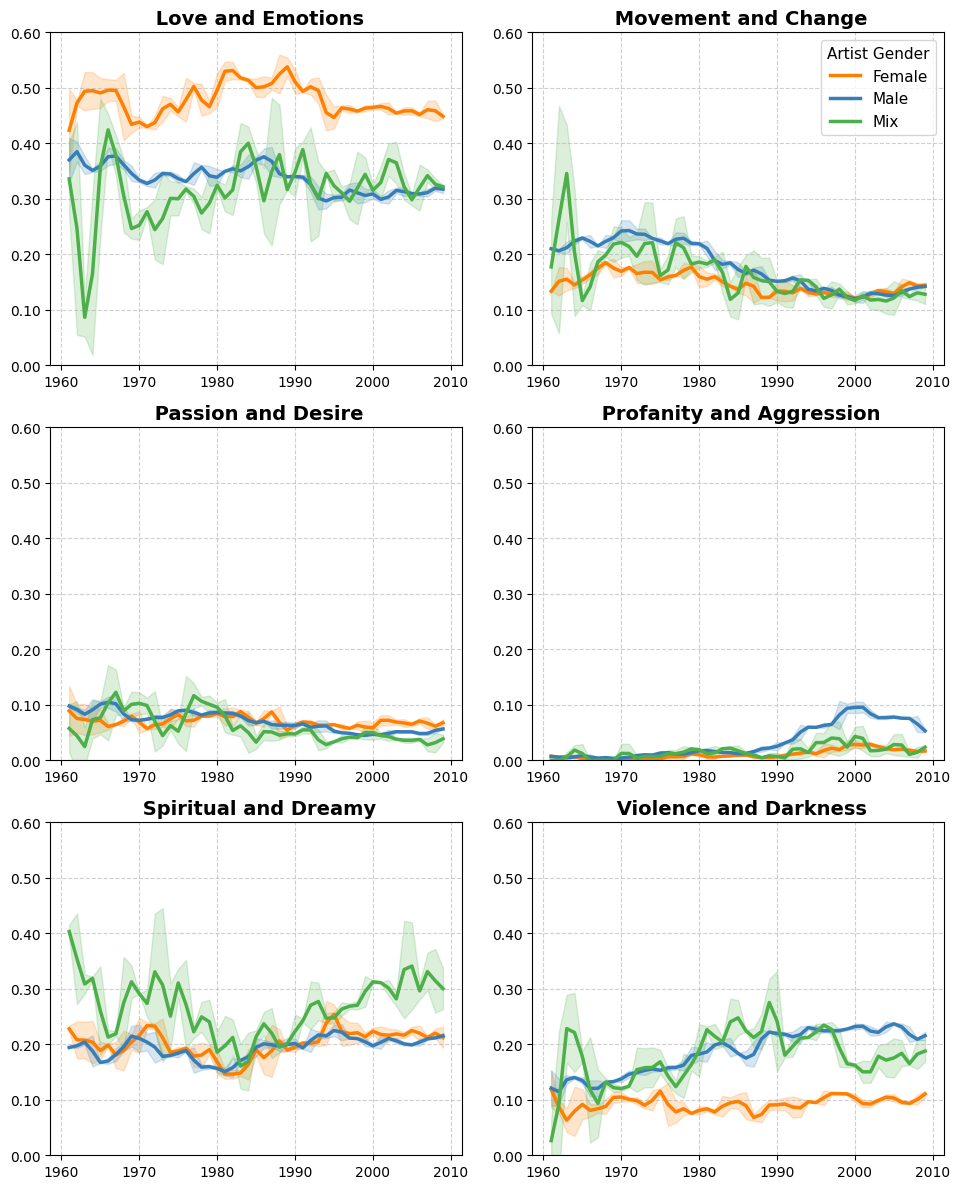

In [ ]:
from matplotlib.ticker import FormatStrFormatter

def plot_trend_with_ci_inline(data, x, y, hue, title, xlabel, ylabel, ci_window=2, custom_palette=None, show_legend=False):
    # Create a rolling mean and confidence interval
    data = data.copy()
    data["mean"] = data.groupby(hue)[y].transform(lambda x: x.rolling(ci_window, center=True).mean())
    data["ci"] = data.groupby(hue)[y].transform(lambda x: x.rolling(ci_window, center=True).std())

    # Plot using seaborn with a custom palette
    sns.lineplot(data=data, x=x, y="mean", hue=hue, ci=None, linewidth=2.5, palette=custom_palette)
    for group in data[hue].unique():
        group_data = data[data[hue] == group]
        plt.fill_between(
            group_data[x],
            group_data["mean"] - group_data["ci"],
            group_data["mean"] + group_data["ci"],
            alpha=0.2,
            color=custom_palette[group]
        )

    # Enhance the plot appearance
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    # plt.legend(title=legend_title, title_fontsize =13, fontsize=13, loc="upper right")  # Use custom legend title
    if show_legend:
        plt.legend(title="Artist Gender", title_fontsize=11, fontsize=11, loc="best")
    else:
        plt.legend().remove()   # Remove legend for other subplots


# Prepare data:
filtered_data = artist_gender_trends[artist_gender_trends["artist_gender"].isin(["Male", "Female", "Mix"])]

# Define a custom color palette
gender_palette = {"Male": "#377eb8", "Female": "#ff7f00", "Mix": "#4daf4a"}

# List of song topics to iterate over
song_topics = ['Love and Emotions', 'Movement and Change',
       'Passion and Desire', 'Profanity and Aggression',
       'Spiritual and Dreamy', 'Violence and Darkness']

# Plot in a grid (2 graphs per row, 5 rows in total)
rows = 3
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, song_topic in enumerate(song_topics):
    row = i // cols
    col = i % cols
    plt.sca(axes[row, col])  # Set current axis
    # Show legend only for "Love and Emotions"
    show_legend = song_topic in ['Movement and Change']

    plot_trend_with_ci_inline(
        data=filtered_data,
        x="song_year_combined",
        y=song_topic,
        hue="artist_gender",
        title=f" {song_topic}",
        xlabel="",
        ylabel="",  # Suppress y-axis label here
        ci_window=2,
        custom_palette=gender_palette,  # Apply custom colors
        show_legend=show_legend  # Custom legend title
    )

    # Format y-axis to 2 decimal places
    axes[row, col].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    # Adjust spacing between rows to be tighter and columns
    plt.subplots_adjust(wspace=7)
    plt.ylim(0, 0.6)  # Set y-axis range
# Adjust layout and display
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/My_PhD_Research/WASABI-Billboard-Analysis/Wasabi_Graphs/Overall_song_themes_trends_Wasabi_v2.pdf", dpi=300)
plt.show()
